# Examples for running FLORIS

In [1]:
# load modules
from floris.floris import Floris
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Setup floris and process input file

In [2]:
floris = Floris("example_input.json")

## Calculate Wake

In [3]:
import time

t1 = time.time()

floris.farm.flow_field.calculate_wake()

t2 = time.time()

print('Time to compute wake = ', t2-t1, 's')

Time to compute wake =  0.015001773834228516 s


## Compute Velocities at each Turbine

In [4]:
for coord, turbine in floris.farm.turbine_map.items():
    print(str(coord) + ":")
    print("\tCp -", turbine.Cp)
    print("\tCt -", turbine.Ct)
    print("\tpower -", turbine.power)
    print("\tai -", turbine.aI)
    print("\taverage velocity -", turbine.get_average_velocity())

(0.0, 0.0):
	Cp - 0.46328782548262326
	Ct - 0.7661304442831962
	power - 1712005.1679717556
	ai - 0.2581996920407235
	average velocity - 7.85065163365446
(800.0, 0.0):
	Cp - 0.4591295490754733
	Ct - 0.8126343857218721
	power - 946340.4076651493
	ai - 0.2835712505937994
	average velocity - 6.462368096236684
(0.0, 630.0):
	Cp - 0.46328782548262326
	Ct - 0.7661304442831962
	power - 1712005.1679717556
	ai - 0.2581996920407235
	average velocity - 7.85065163365446
(800.0, 630.0):
	Cp - 0.4591295490754733
	Ct - 0.8126343857218721
	power - 946340.4076651493
	ai - 0.2835712505937994
	average velocity - 6.462368096236684


## Visualization Manager for FLORIS 

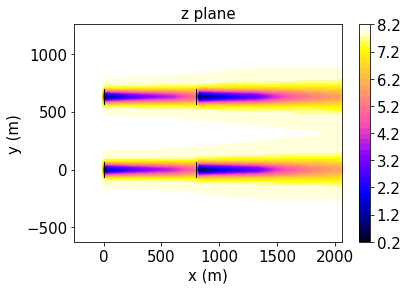

In [5]:
# Visualization
from copy import deepcopy
from floris.vis import VisualizationManager

ff_viz = deepcopy(floris.farm.flow_field)
grid_resolution = (100, 100, 25)
visualization_manager = VisualizationManager(ff_viz, grid_resolution)
visualization_manager.plot_z_planes([0.5])
#visualization_manager.plot_x_planes([0.5])

## Incorporate Different Turbines

In [6]:
for i,(coord, turbine) in enumerate(floris.farm.turbine_map.items()):
    if i == 2 or i == 3:
        turbine.rotor_diameter = 50.0
        turbine.rotor_radius = turbine.rotor_diameter/2.
        turbine.hub_height = 70.0
        turbine.TSR = 7.0
        
        # note: these are the Cp/Ct tables for the NREL 5MW turbine.  
        turbine.power_thrust_table["power"] = [0.0,0.15643578,0.31287155,0.41306749,0.44895632,0.46155227,0.46330747,
                                                   0.46316077,0.46316077,0.46280642,0.45223111,0.39353012,0.3424487,
                                                   0.2979978, 0.25931677,0.22565665,0.19636572,0.17087684,0.1486965,
                                                   0.12939524,0.11259934,0.0979836, 0.08526502,0.07419736,0.06456631,
                                                   0.05618541,0.04889237,0.0]
        turbine.power_thrust_table["thrust"] = [1.10610965,1.09515807,1.0227122, 0.9196487, 0.85190470,0.80328229,0.76675469,
                                                0.76209299,0.76209299,0.75083241,0.67210674,0.52188504,0.43178758,0.36443258,
                                                0.31049874,0.26696686,0.22986909,0.19961578,0.17286245,0.15081457,0.13146666,
                                                0.11475968,0.10129584,0.0880188, 0.07746819,0.06878621,0.05977061,0.0]
        turbine.power_thrust_table["wind_speed"] = [0.0,2.5,3.52338654,4.57015961, 5.61693268, 6.66370575, 7.71047882, 8.75725189,
                                                    9.80402496,10.85079803,11.70448774,12.25970155,12.84125247,13.45038983,
                                                    14.08842222,14.75672029,15.45671974,16.18992434,16.95790922,17.76232421,
                                                    18.60489742,19.48743891,20.41184461,21.38010041,22.39428636,23.45658122,
                                                    24.56926707,30.0]
        
floris.farm.flow_field.calculate_wake()

## Visualize Different Turbines

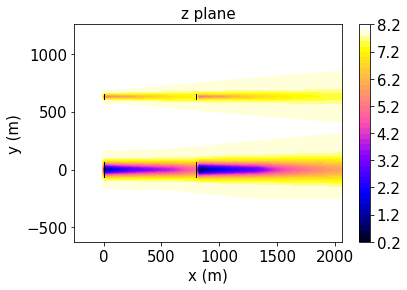

In [7]:
ff_viz = deepcopy(floris.farm.flow_field)
grid_resolution = (100, 100, 25)
visualization_manager = VisualizationManager(ff_viz, grid_resolution)
visualization_manager.plot_z_planes([0.5])
#visualization_manager.plot_y_planes([0.5])

## Optimize Wind Farm using Wake Steering 

In [8]:
from floris.opt import wake_steering
import numpy as np

# run FLORIS with no yaw
turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
for k,turbine in enumerate(turbines):
    turbine.yaw_angle = 0.0
floris.farm.flow_field.calculate_wake()
power_initial = np.sum([turbine.power for turbine in turbines])  # determine initial power production

# number of turbines
nTurbs = len(turbines)

# set bounds for the optimization on the yaw angles (deg)
minimum_yaw_angle = 0.0
maximum_yaw_angle = 25.0

# compute the optimal yaw angles
opt_yaw_angles = wake_steering(floris,minimum_yaw_angle,maximum_yaw_angle)

print('Optimal yaw angles for:')
for i,yaw in enumerate(opt_yaw_angles):
    print('Turbine ', i, ' yaw angle = ', np.degrees(yaw))

Optimizing wake redirection control...
Number of parameters to optimize =  4
Optimal yaw angles for:
Turbine  0  yaw angle =  25.0
Turbine  1  yaw angle =  0.0
Turbine  2  yaw angle =  0.0
Turbine  3  yaw angle =  0.0


## Calculate Power Gain

In [9]:
# assign yaw angles to turbines
turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
for i,turbine in enumerate(turbines):
    turbine.yaw_angle = opt_yaw_angles[i]
    
# compute the new wake with yaw angles
floris.farm.flow_field.calculate_wake()

# optimal power 
power_opt = np.sum([turbine.power for turbine in turbines]) 

print('Power increased by ', 100*(power_opt-power_initial)/power_initial, '%')

Power increased by  5.208122084915281 %
